In [2]:
# ============================================================
# Task 1 + Task 2: Data Preprocessing + LSTM Classifier
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple
from joblib import dump

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Deep Learning Imports

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ---------- Paths ----------
ROOT = Path(".").resolve()
TRAIN_CSV = ROOT / "train-final.csv"
TEST_CSV  = ROOT / "test-final.csv"
ARTIFACT_DIR = ROOT / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

GESTURE_LIST = [
    "afternoon","baby","big","born","bye","calendar",
    "child","cloud","come","daily","dance","dark",
    "day","enjoy","go","hello","home","love",
    "my","name","no","rain","sorry","strong",
    "study","thankyou","welcome","wind","yes","you"
]
GESTURE_TO_ID = {g: i+1 for i, g in enumerate(GESTURE_LIST)}

# ---------- Load CSVs ----------
def load_raw(path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    df = pd.read_csv(path, header=None)
    if df.shape[1] < 241:
        raise ValueError(f"Expected at least 241 columns (240 features + label). Found {df.shape[1]} in {path}.")
    return df

train_raw = load_raw(TRAIN_CSV)
test_raw  = load_raw(TEST_CSV)
print(f"Train shape: {train_raw.shape} | Test shape: {test_raw.shape}")

Train shape: (2161, 246) | Test shape: (541, 246)


In [3]:
# ---------- Split features & labels ----------
def split_features_labels(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    feat = df.iloc[:, :240].copy()
    for c in feat.columns:
        feat[c] = pd.to_numeric(feat[c], errors="coerce")

    meta = df.iloc[:, 240:].copy()
    meta.columns = [f"col_{i}" for i in range(meta.shape[1])]

    labels = pd.DataFrame(index=df.index)

    obj_cols = [c for c in meta.columns if meta[c].dtype == "object"]
    if obj_cols:
        labels["label_name"] = meta[obj_cols[0]].astype(str)

    num_candidate = None
    for c in meta.columns:
        coerced = pd.to_numeric(meta[c], errors="coerce")
        if coerced.notna().mean() > 0.9:
            num_candidate = c
            break
    if num_candidate is not None:
        labels["label_id"] = pd.to_numeric(meta[num_candidate], errors="coerce").astype("Int64")

    if len(obj_cols) >= 2:
        labels["candidate"] = meta[obj_cols[1]].astype(str)

    if "label_name" in labels.columns:
        labels["label_id_mapped"] = labels["label_name"].str.lower().map(GESTURE_TO_ID)
        labels["label_id_final"] = labels.get("label_id", labels["label_id_mapped"]).fillna(labels["label_id_mapped"])
    elif "label_id" in labels.columns:
        labels["label_id_final"] = labels["label_id"]

    return feat, labels

X_train_raw, y_train_df = split_features_labels(train_raw)
X_test_raw,  y_test_df  = split_features_labels(test_raw)
print("Columns in labels (train):", list(y_train_df.columns))
print("Columns in labels (test): ", list(y_test_df.columns))

Columns in labels (train): ['label_name', 'label_id', 'candidate', 'label_id_mapped', 'label_id_final']
Columns in labels (test):  ['label_name', 'label_id', 'candidate', 'label_id_mapped', 'label_id_final']


In [4]:
# ---------- Impute & Scale ----------
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed  = imputer.transform(X_test_raw)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

dump(imputer, ARTIFACT_DIR / "imputer.pkl")
dump(scaler,  ARTIFACT_DIR / "scaler.pkl")
print("Saved artifacts: artifacts/imputer.pkl, artifacts/scaler.pkl")

Saved artifacts: artifacts/imputer.pkl, artifacts/scaler.pkl


Saved processed_train.csv (2161, 245) and processed_test.csv (541, 245)

=== Descriptive stats (train, scaled features) ===
             f1        f2        f3        f4        f5        f6        f7  \
count  2161.000  2161.000  2161.000  2161.000  2161.000  2161.000  2161.000   
mean      0.000     0.000    -0.000    -0.000     0.000    -0.000     0.000   
std       1.000     1.000     1.000     1.000     1.000     1.000     1.000   
min      -2.848    -5.759    -4.364    -2.752    -6.540    -3.825    -2.326   
25%      -0.758    -0.508    -0.535    -0.705    -0.534    -0.545    -0.646   
50%       0.126     0.017     0.132     0.116     0.018     0.110     0.059   
75%       0.736     0.520     0.699     0.748     0.529     0.686     0.667   
max       5.239     2.873     2.855     5.126     2.873     2.975     4.834   

             f8        f9       f10  ...      f231      f232      f233  \
count  2161.000  2161.000  2161.000  ...  2161.000  2161.000  2161.000   
mean      0.000 

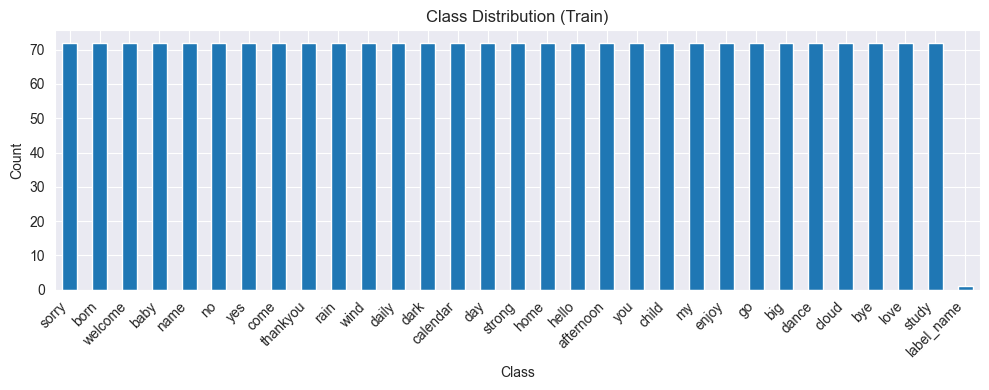

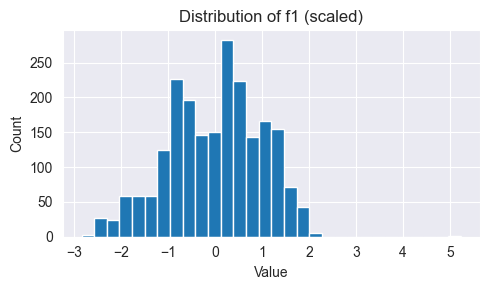

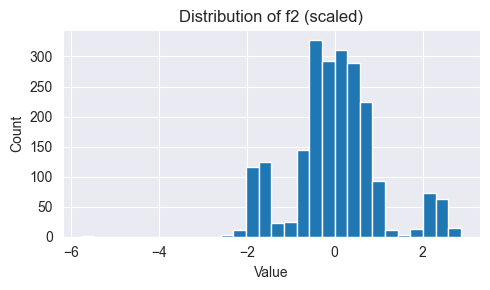

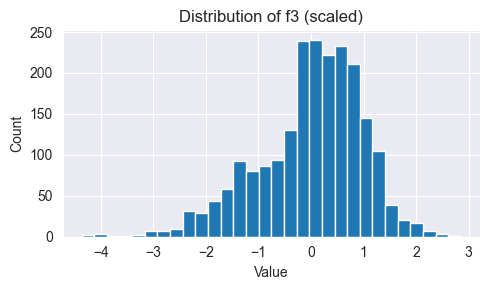

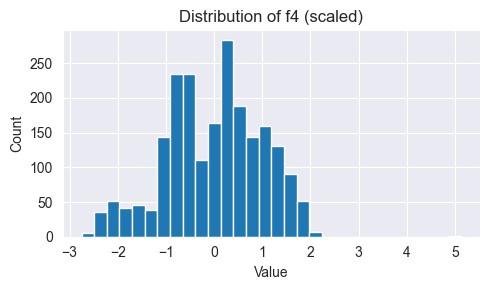

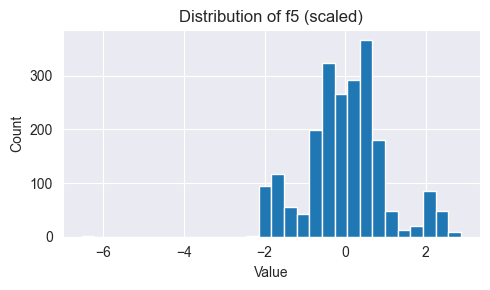

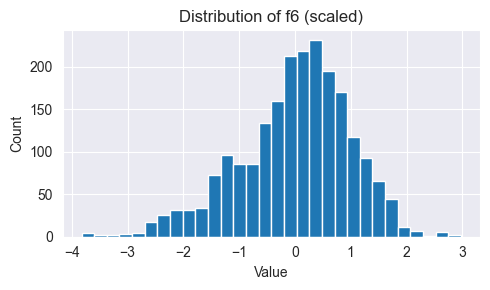

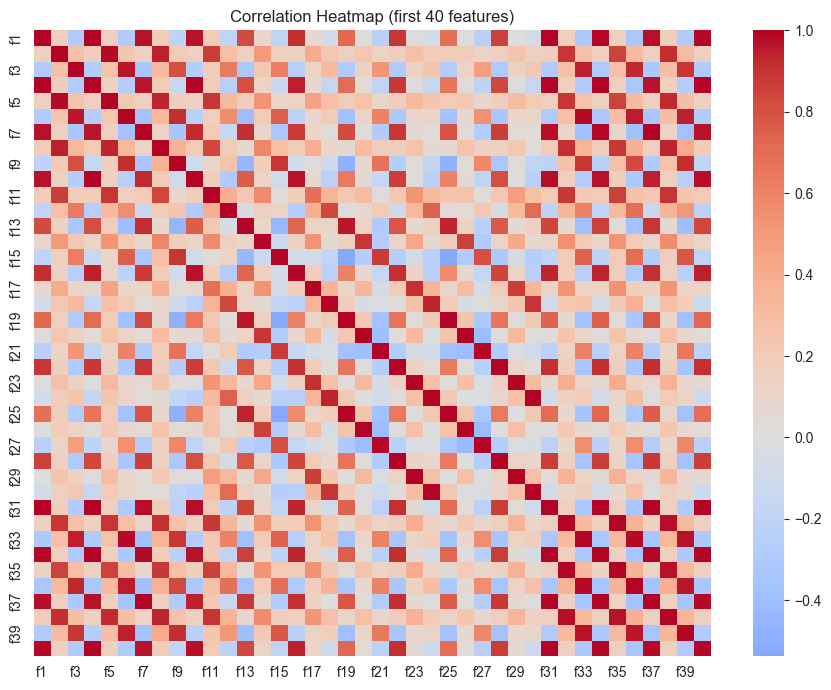

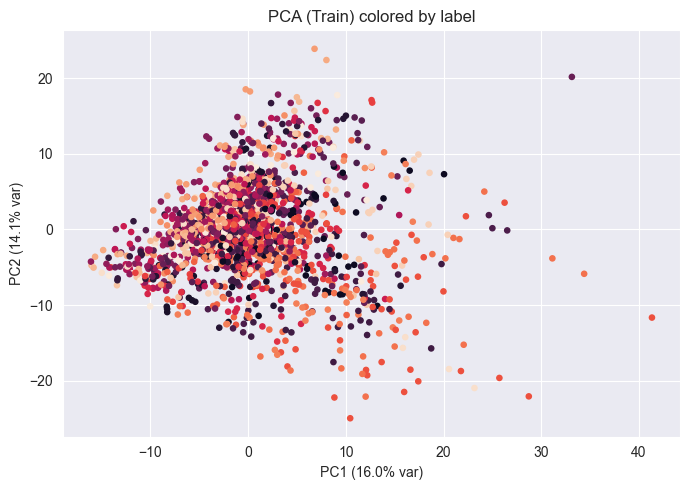


✅ Task 1 Done. Proceeding to Task 2: LSTM Classifier...



In [5]:

feat_cols = [f"f{i+1}" for i in range(240)]
train_proc = pd.DataFrame(X_train_scaled, columns=feat_cols)
test_proc  = pd.DataFrame(X_test_scaled,  columns=feat_cols)

train_out = pd.concat([train_proc, y_train_df.reset_index(drop=True)], axis=1)
test_out  = pd.concat([test_proc,  y_test_df.reset_index(drop=True)],  axis=1)

train_out.to_csv(ROOT / "processed_train.csv", index=False)
test_out.to_csv(ROOT / "processed_test.csv", index=False)
print(f"Saved processed_train.csv {train_out.shape} and processed_test.csv {test_out.shape}")

# ---------- Descriptive analysis & visuals ----------
print("\n=== Descriptive stats (train, scaled features) ===")
print(train_proc.describe().round(3))

missing_rate = X_train_raw.isna().mean().mean()
print(f"\nAverage missing rate in raw train features: {missing_rate:.4f}")

label_series = None
if "label_name" in y_train_df.columns and y_train_df["label_name"].notna().any():
    label_series = y_train_df["label_name"].str.lower()
elif "label_id_final" in y_train_df.columns and y_train_df["label_id_final"].notna().any():
    label_series = y_train_df["label_id_final"].astype(str)

if label_series is not None:
    plt.figure(figsize=(10,4))
    label_series.value_counts().plot(kind="bar")
    plt.title("Class Distribution (Train)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for c in feat_cols[:6]:
    plt.figure(figsize=(5,3))
    plt.hist(train_proc[c], bins=30)
    plt.title(f"Distribution of {c} (scaled)")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

subset = feat_cols[:40]
corr = pd.DataFrame(train_proc[subset]).corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (first 40 features)")
plt.tight_layout()
plt.show()

try:
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(train_proc.values)
    plt.figure(figsize=(7,5))
    if label_series is not None:
        labs = label_series.fillna("unknown")
        uniq = labs.unique().tolist()
        color_idx = {lab: i for i, lab in enumerate(uniq)}
        plt.scatter(Z[:,0], Z[:,1], c=[color_idx[x] for x in labs], s=14)
        plt.title("PCA (Train) colored by label")
    else:
        plt.scatter(Z[:,0], Z[:,1], s=14)
        plt.title("PCA (Train)")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("PCA plot skipped:", e)

print("\n✅ Task 1 Done. Proceeding to Task 2: LSTM Classifier...\n")

In [11]:
from keras.src.utils import to_categorical

# ============================================================
# TASK 2: LSTM CLASSIFIER
# ============================================================

# ---------- Load Processed Data ----------
train_df = pd.read_csv(ROOT / "processed_train.csv")
test_df  = pd.read_csv(ROOT / "processed_test.csv")

train_df = train_df.dropna(subset=["label_id_final"])
test_df  = test_df.dropna(subset=["label_id_final"])

y_train = train_df["label_id_final"].astype(int).values
y_test  = test_df["label_id_final"].astype(int).values

X_train = train_df.iloc[:, :240].values
X_test  = test_df.iloc[:, :240].values

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train - 1, num_classes=num_classes)
y_test_cat  = to_categorical(y_test - 1,  num_classes=num_classes)

# ---------- Reshape Data for LSTM ----------
X_train_seq = X_train.reshape((X_train.shape[0], 240, 1))
X_test_seq  = X_test.reshape((X_test.shape[0], 240, 1))
print("Reshaped input to:", X_train_seq.shape)

Reshaped input to: (2160, 240, 1)


In [12]:
from keras.src.callbacks import EarlyStopping
from keras.src.layers import Dropout, LSTM, Dense
from keras import Sequential


# ---------- Define LSTM Model ----------
model = Sequential([
    LSTM(128, input_shape=(240, 1), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# ---------- Train Model ----------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,401 (294.54 KB)

 Trainable params: 75,401 (294.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.1405 - loss: 2.1731 - val_accuracy: 0.1227 - val_loss: 2.1625
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.1500 - loss: 2.1377 - val_accuracy: 0.1366 - val_loss: 2.1397
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.1695 - loss: 2.1222 - val_accuracy: 0.1366 - val_loss: 2.1359
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.1571 - loss: 2.1113 - val_accuracy: 0.1389 - val_loss: 2.1257
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.1659 - loss: 2.1061 - val_accuracy: 0.1319 - val_loss: 2.1179
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.1784 - loss: 2.0739 - val_accuracy: 0.1736 - val_loss: 2.0484
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.1826 - loss: 2.0460 - val_accuracy: 0.1806 - val_loss: 2.0373
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.1864 - loss: 2.0255 - val_accuracy: 0.1667 -

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

✅ Test Accuracy: 0.2278

Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.17      0.18        54
           2       0.25      0.47      0.32        60
           3       0.21      0.14      0.17        65
           4       0.23      0.43      0.30        49
           5       0.00      0.00      0.00        58
           6       0.17      0.01      0.03        68
           7       0.41      0.27      0.32        64
           8       0.00      0.00      0.00        63
           9       0.20      0.64      0.30        59

    accuracy                           0.23       540
   macro avg       0.18      0.24      0.18       540
weighted avg       0.18      0.23      0.18       540



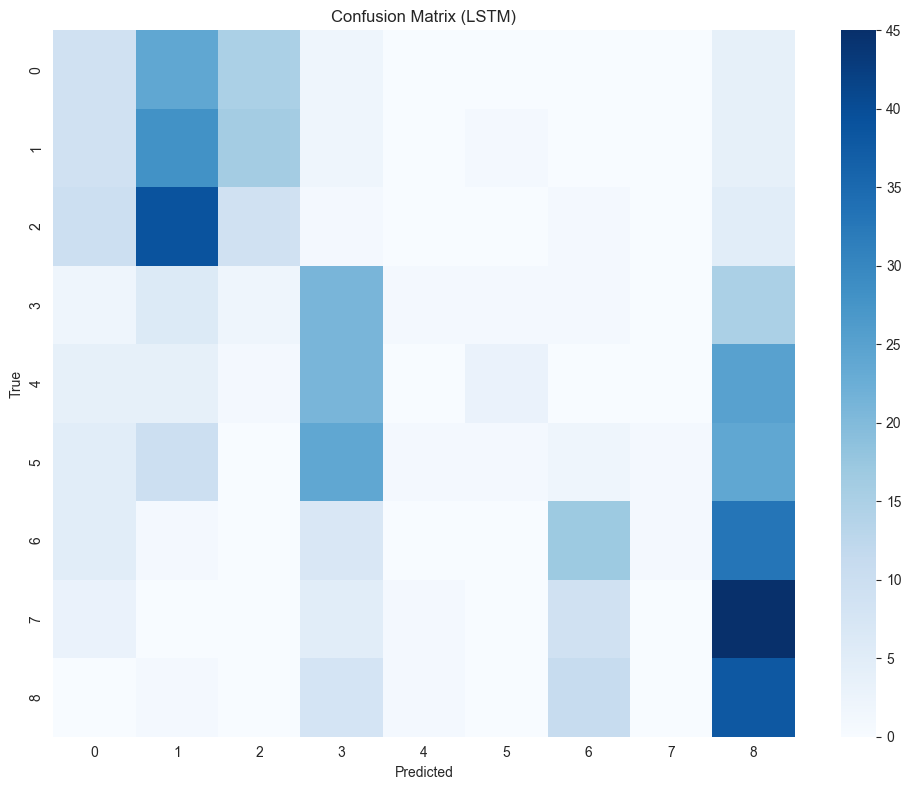

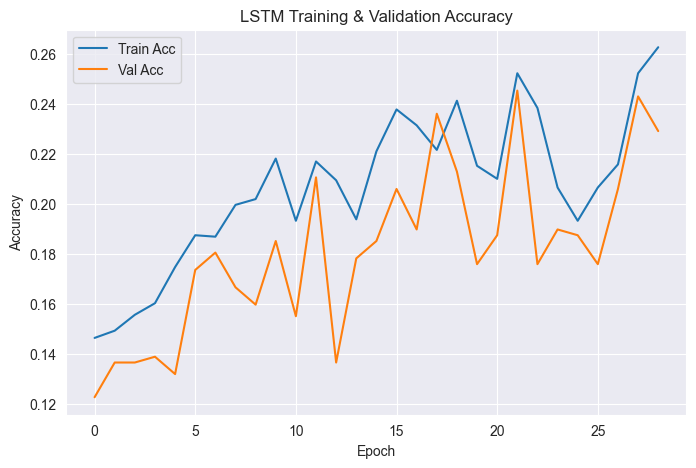

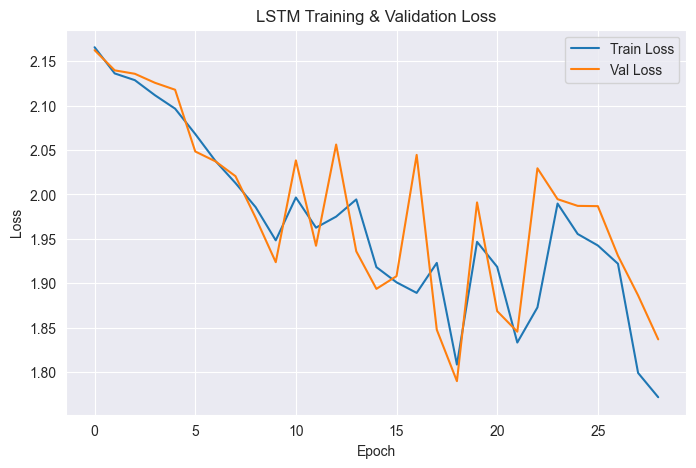

In [13]:
# ---------- Evaluate ----------
y_pred_prob = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_prob, axis=1) + 1  # back to label ids

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix (LSTM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---------- Training Curves ----------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("LSTM Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()